In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import glob

In [2]:
from utils import volGK_time_id, rel_vol_time_id

In [3]:
train = pd.read_csv("optiver-realized-volatility-prediction/train.csv")

train.shape

(428932, 3)

In [4]:
order_book_training = glob.glob('optiver-realized-volatility-prediction/book_train.parquet/*')

In [5]:
%%time 
stock_id = []
time_id = []
relvol = []
volgk = []

for i in order_book_training[:10]:
    # finding the stock_id
    temp_stock = int(i.split("=")[1])
    # find the realized volatility for all time_id of temp_stock
    temp_relvol = rel_vol_time_id(i)
    stock_id += [temp_stock]*temp_relvol.shape[0]
    time_id += list(temp_relvol.index)
    relvol += list(temp_relvol)
    volgk += list(volGK_time_id(i))

CPU times: user 5.08 s, sys: 270 ms, total: 5.35 s
Wall time: 4.76 s


In [ ]:
past_vol = pd.DataFrame({"stock_id": stock_id, "time_id": time_id, "rel_vol": relvol, "vol_gk": volgk})

numpy.float64

In [9]:
joined = train.merge(past_vol, on = ["stock_id","time_id"])
joined

,stock_id,time_id,target,rel_vol,vol_gk
0,10,5,0.005707,0.005378,0.004366
1,10,11,0.002352,0.002376,0.001740
2,10,16,0.002363,0.002343,0.001485
3,10,31,0.002341,0.002042,0.000823
4,10,62,0.002007,0.001426,0.001333
...,...,...,...,...,...
38294,86,32751,0.002334,0.002856,0.002957
38295,86,32753,0.002954,0.003425,0.003637
38296,86,32758,0.001912,0.001839,0.001464
38297,86,32763,0.005269,0.001742,0.001485


In [10]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [ ]:
print(f'The RMSPE score of the native prediciton for the training set is {rmspe(joined["target"], joined["rel_vol"])}')
print(f'The RMSPE score of the native prediciton for the training set is {rmspe(joined["target"], joined["vol_gk"])}')

The RMSPE score of the native prediciton for the training set is 0.340856751663662
The R2 score of the native prediciton for the training set is 0.3976766148405539


## Features

- Weighted Average Price (WAP)
- Volume and Volume Imbalance
- Bid/Ask spread

## OLS

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# for training
def linear_training(X,y,degree):
    # instantiating polynomial features
    polyfeat = PolynomialFeatures(degree = degree)
    linreg = LinearRegression()
    # preprocessing the training data
    x = np.array(X).reshape(-1,1)
    # creating the polynomial features
    X_ = polyfeat.fit_transform(x)
    # training the model
    # weights = 1/np.square(y)
    weights = np.ones(len(y))
    return linreg.fit(X_, np.array(y).reshape(-1,1), sample_weight = weights)


stock_id_train = train.stock_id.unique() # all stock_id for the train set
models = {} # dictionary for holding trained models for each stock_id
degree = 2
for i in stock_id_train:
    temp = joined[joined["stock_id"]==i]
    X = temp["volatility"]
    y = temp["target"]
    models[i] = linear_training(X,y,degree)

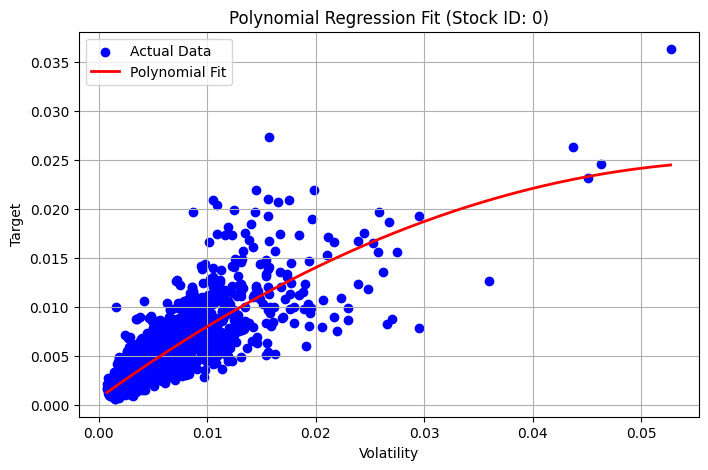

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_fit(stock_id, models, joined, degree):
    # Extract data for this stock
    temp = joined[joined["stock_id"] == stock_id]
    X = temp["volatility"].values
    y = temp["target"].values
    
    # Get model for this stock
    model = models[stock_id]
    
    # Prepare a range of volatility values for smooth curve
    x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    polyfeat = PolynomialFeatures(degree=degree)
    X_poly = polyfeat.fit_transform(x_range)
    
    # Predict with the model
    y_pred = model.predict(X_poly)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(x_range, y_pred, color='red', linewidth=2, label='Polynomial Fit')
    plt.title(f"Polynomial Regression Fit (Stock ID: {stock_id})")
    plt.xlabel("Volatility")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.savefig("regression.png", dpi=300, bbox_inches='tight')

    plt.show()

# Example: plot for the first stock ID
plot_model_fit(stock_id_train[0], models, joined, degree)

In [24]:
def linear_inference(models, stock_id, past_volatility, degree):
    model = models[stock_id]
    polyfeat = PolynomialFeatures(degree = degree)
    return model.predict(polyfeat.fit_transform([[past_volatility]]))[0][0]

In [26]:
submission = pd.DataFrame({"stock_id": [], "time_id": [], "pred": []})

submission[["stock_id","time_id"]] = past_volatility[["stock_id","time_id"]]

In [27]:
submission["target"] = past_volatility.apply(lambda x: linear_inference(models,\
                                                                            x.stock_id,\
                                                                            x.volatility,\
                                                                            degree),\
                                                 axis = 1)

In [28]:
submission.drop(columns = ["pred"], inplace = True)

In [29]:
submission.sort_values(by = ["stock_id","time_id"], inplace = True)

In [30]:
submission.rename(columns = {"target": "pred"}, inplace = True)

In [31]:
joined2 = train.merge(submission, on = ["stock_id","time_id"], how = "left")
R2 = round(r2_score(y_true = joined2['target'], y_pred = joined2['pred']),3)
print(f'The R2 score of the naive prediction for training set is {R2}')

The R2 score of the naive prediction for training set is 0.792


In [32]:
joined2

,stock_id,time_id,target,pred
0,0,5,0.004136,0.004148
1,0,11,0.001445,0.001638
2,0,16,0.002168,0.002541
3,0,31,0.002195,0.002699
4,0,62,0.001747,0.002176
...,...,...,...,...
428927,126,32751,0.003461,0.003797
428928,126,32753,0.003113,0.004151
428929,126,32758,0.004070,0.003297
428930,126,32763,0.003357,0.003771


In [33]:
rmspe(joined2["target"], joined2["pred"])

np.float64(0.29966188059626525)

## Time Series Reconstruction

In [31]:
time_id_order = pd.read_csv("time_id_order.csv")
time_id_order.drop(columns = ["Unnamed: 0"], inplace = True)
time_id_order.head()

,time_id
0,4294
1,24033
2,5666
3,29740
4,22178


In [38]:
CHTR = "optiver-realized-volatility-prediction/book_train.parquet/stock_id=61"
CHTR = wap(CHTR)
CHTR.set_index("time_id", inplace = True)
CHTR.head()

,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,WAP
time_id,,,,,,,,,,
5,0,0.998834,0.999695,0.998756,0.999760,23,1,1,1,0.999659
5,1,0.998997,0.999695,0.998834,0.999760,1,1,23,1,0.999346
5,2,0.998997,0.999633,0.998834,0.999695,1,1,23,1,0.999315
5,3,0.998640,0.999182,0.998555,0.999276,1,1,1,27,0.998911
5,4,0.998640,0.999276,0.998506,0.999292,1,27,100,1,0.998662


In [44]:
CHTR_sorted = CHTR.loc[time_id_order["time_id"].values].reset_index()
CHTR_sorted.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,WAP
0,4294,0,0.999376,0.999941,0.999370,1.000107,100,100,5,200,0.999659
1,4294,1,0.999285,0.999851,0.999269,0.999883,11,100,10,5,0.999341
2,4294,2,0.999296,0.999851,0.999290,0.999883,100,100,100,5,0.999573
3,4294,3,0.999290,0.999851,0.999285,0.999883,100,142,11,5,0.999522
4,4294,4,0.999306,0.999819,0.999301,0.999851,100,20,10,142,0.999733
